In [66]:
import pandas as pd
import string
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np


from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer(reduce_len=True)

# Feature Engineering

In [6]:
# read the raw data and show the data
raw_data = pd.read_csv("./Data/Raw/ExtractedTweets.csv")
raw_data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [7]:
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def remove_punctuations(t):
    t = re.sub('@\w+','', t)
    t = "".join([char for char in t if char not in string.punctuation])
    t = re.sub('[0-9]+', '', t)
    return t

def tokenization(t):
    t = re.split('\W+', t)
    return t

def remove_stop_words(t):
    t = [word for word in t if word not in stopword]
    t = [word for word in t if word not in ['rt']]
    return t

def stemming(t):
    t = [ps.stem(word) for word in t]
    return t

In [8]:
def cleaner(t):
    t = remove_punctuations(t).lower()
    t = tokenization(t)
    t = remove_stop_words(t)
    t = stemming(t)
    return t

In [9]:
raw_data['cleaned'] = raw_data.Tweet.apply(lambda x: " ".join(cleaner(x)))
raw_data.head(10)

,Party,Handle,Tweet,cleaned
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senat dem vote savetheinternet proud sup...
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winter resid alta vista teacher one sever reco...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,note hurrican maria left approxim billion dama...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,meet thank take time meet ed marucci guzman na...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,hurrican season start june st puerto rico read...
5,Democrat,RepDarrenSoto,RT @EmgageActionFL: Thank you to all who came ...,thank came orlando gala success night would po...
6,Democrat,RepDarrenSoto,Hurricane Maria left approx $90 billion in dam...,hurrican maria left approx billion damag yet b...
7,Democrat,RepDarrenSoto,RT @Tharryry: I am delighted that @RepDarrenSo...,delight vote cra overrul fcc save netneutr rul...
8,Democrat,RepDarrenSoto,RT @HispanicCaucus: Trump's anti-immigrant pol...,trump antiimmigr polici hurt small busi across...
9,Democrat,RepDarrenSoto,RT @RepStephMurphy: Great joining @WeAreUnidos...,great join roundtabl orlando feder issu affect...


In [50]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.cleaned,raw_data.Party, stratify=raw_data.Party, test_size = 0.2, random_state=123)

# Model Selection

In [11]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB())
])

In [12]:
nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier', MultinomialNB())])

In [13]:
preds = nb_pipleline.predict(X_test)
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, preds), 4))))

Accuracy: 0.7554


## Gridsearch on naive bayes

In [43]:
nb_params = [{'classifier__alpha': [3,2,1,0.1, 0.01, 0.001, 0.0001, 0.00001]}]
gs = GridSearchCV(estimator=nb_pipleline, param_grid=nb_params, refit=True, cv=4, n_jobs=-1)
gs.fit(X_train, y_train)
print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

Best Accuracy: 75.94%
Best Params: {'classifier__alpha': 0.1}


<BarContainer object of 8 artists>

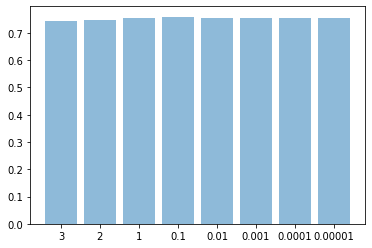

In [44]:
plt.bar(['3','2','1','0.1', '0.01', '0.001', '0.0001', '0.00001'],gs.cv_results_['mean_test_score'],align='center', alpha=0.5 )

In [14]:
nb_pipleline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', MultinomialNB(alpha=0.1))
])

nb_pipleline.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier', MultinomialNB(alpha=0.1))])

In [15]:
nb_scores = cross_val_score(nb_pipleline, X_train, y_train, cv=4, n_jobs=-1)

In [41]:
nb_cv_avg = nb_scores.sum()/4

In [42]:
nb_cv_avg

0.7593684941013185

## SVM

In [98]:
svm_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', SVC(kernel='linear'))
])

In [ ]:
svm_scores = cross_val_score(svm_pipe, X_train, y_train, cv=4, n_jobs=-1)
svm_scores

In [33]:
svm_cv_avg = svm_scores.sum()/4
svm_cv_avg

0.7642840619939857

In [55]:
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier', SVC())])

### Gridsearch on SVM
We will use linear kernal in this case, the only hyperparameter that we care is c

In [100]:
svm_params = [{'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
gs_svm_linear = GridSearchCV(estimator=svm_pipe, param_grid=svm_params, refit=True, cv=4, n_jobs=-1)
gs_svm_linear.fit(X_train, y_train)

NameError: name 'gs' is not defined

In [101]:
print('Best Accuracy: %.2f%%' % (gs_svm_linear.best_score_*100))
print('Best Params:', gs_svm_linear.best_params_)

Best Accuracy: 75.55%
Best Params: {'classifier__C': 1}


In [105]:
gs_svm_linear.cv_results_

{'mean_fit_time': array([ 764.9028638 ,  758.13181806,  741.95847076,  652.16607904,
        1090.23457623, 3490.57218248]),
 'std_fit_time': array([ 0.48240538,  1.10489355,  0.69683284, 12.22376535, 58.2563761 ,
        24.42130699]),
 'mean_score_time': array([153.45407653, 152.22606462, 151.425493  , 122.28367418,
         79.53728074,  62.32741499]),
 'std_score_time': array([0.68446518, 0.16284618, 0.55434499, 1.43942263, 1.73535659,
        3.55256043]),
 'param_classifier__C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__C': 0.0001},
  {'classifier__C': 0.001},
  {'classifier__C': 0.01},
  {'classifier__C': 0.1},
  {'classifier__C': 1},
  {'classifier__C': 10}],
 'split0_test_score': array([0.51341661, 0.51341661, 0.56263012, 0.7253065 , 0.75693963,
        0.74728198]),
 'split1_test_score': array([0.51341661, 0.51341661, 0.563786

## Randomnized search on XGBoost

In [50]:
import scipy.stats

d = {'classifier__max_depth':[5,6,7,8,9,10],
     'classifier__min_child_weight': scipy.stats.uniform(loc=0, scale=10),
     'classifier__eta': scipy.stats.uniform(loc=0, scale=2)}

In [51]:
xgb_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.2, nthreads=-1))
])

rs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=d, n_iter=10, cv=4, refit=True, random_state=123, n_jobs=-1)

In [53]:
xgb_pipe.fit(X_train, y_train)
xgb_preds = xgb_pipe.predict(X_test)

In [23]:
xgb_pipe_best = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=9, n_estimators=300, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier',
                 XGBClassifier(learning_rate=1.06, max_depth=9,
                               min_child_weight=4.27, n_estimators=300,
                               nthreads=-1))])

In [26]:
xgb_pipe_best = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=9, n_estimators=300, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best.fit(X_train, y_train)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7faa8d8b5470>>)),
                ('classifier',
                 XGBClassifier(learning_rate=1.06, max_depth=9,
                               min_child_weight=4.27, n_estimators=300,
                               nthreads=-1))])

In [106]:
xgb_pipe_best_1 = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=tokenizer.tokenize)),
    ('classifier', XGBClassifier(max_depth=15, n_estimators=200, learning_rate=1.06, min_child_weight=4.27, nthreads=-1))
])

xgb_pipe_best_1.fit(X_train, y_train)

0.6887288919731668

In [108]:
xgb_best_1_preds = xgb_pipe_best_1.predict(X_test)

In [109]:
accuracy_score(xgb_best_1_preds, y_test)

0.691822808235022

In [107]:
svm_scores_1 = cross_val_score(xgb_pipe_best_1, X_train, y_train, cv=4, n_jobs=-1)
xgb_cv_avg_1 = xgb_scores.sum()/4
xgb_cv_avg_1

KeyboardInterrupt: 

In [27]:
svm_scores = cross_val_score(xgb_pipe_best, X_train, y_train, cv=4, n_jobs=-1)

In [36]:
xgb_cv_avg = xgb_scores.sum()/4

In [37]:
xgb_cv_avg

0.6887288919731668

<BarContainer object of 3 artists>

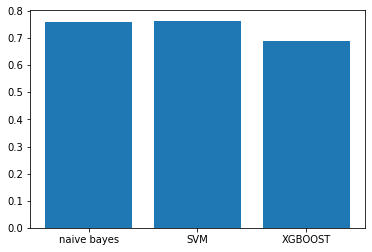

In [43]:
plt.bar(['naive bayes', 'SVM', 'XGBOOST'], [nb_cv_avg, svm_cv_avg, xgb_cv_avg])

From this plot we can see that both naive bayes and SVM perform a noticeble better amount than xgboost

## Model Evaluation

Since we already selected the following models:
    1. svm
    2. multinomial naive bayes
    3. XGBoost
    4. Decision Tree

In [94]:
%time
nb_pred = nb_pipleline.predict(X_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 16 µs


In [95]:
%time
svm_pred = svm_pipe.predict(X_test)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [59]:
xgb_pred = xgb_pipe_best.predict(X_test)

In [61]:
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, nb_pred), 4))))
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, svm_pred), 4))))
print('Accuracy: {}'.format(str(round(accuracy_score(y_test, xgb_pred), 4))))

Accuracy: 0.7569
Accuracy: 0.7642
Accuracy: 0.7002


In [70]:
nb_test_score = round(accuracy_score(y_test, nb_pred), 2)
svm_test_score = round(accuracy_score(y_test, svm_pred), 2)
xgb_test_score = round(accuracy_score(y_test, xgb_pred), 2)

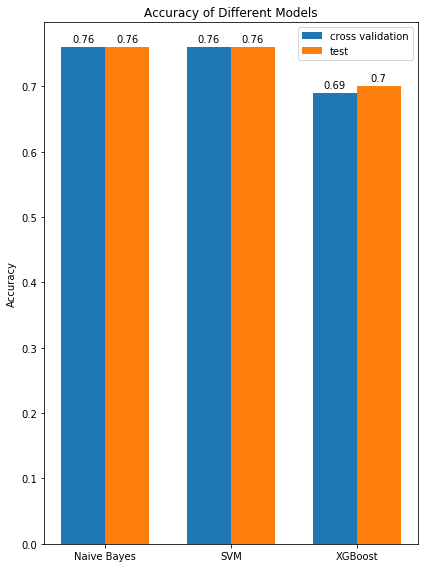

In [76]:
labels = ['Naive Bayes', 'SVM', 'XGBoost']
cv_scores = [round(nb_cv_avg,2), round(svm_cv_avg,2), round(xgb_cv_avg,2)]
test_scores = [nb_test_score, svm_test_score, xgb_test_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cv_scores, width, label='cross validation')
rects2 = ax.bar(x + width/2, test_scores, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.set_figheight(8)
fig.tight_layout()

plt.show()

# Model Comparision
Naive Bayes vs SVM

In [83]:
from sklearn.metrics.cluster import contingency_matrix

In [84]:
svm_cm = confusion_matrix(svm_pred, nb_pred)

In [85]:
svm_cm

array([[6647, 1297],
       [1167, 8181]])

In [87]:
from statsmodels.stats.contingency_tables import mcnemar
result_mcnemar = mcnemar(svm_cm, exact=True)
print('statistic=%.3f, p-value=%.3f' % (result_mcnemar.statistic, result_mcnemar.pvalue))
alpha = 0.05
if result_mcnemar.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=1167.000, p-value=0.009
Different proportions of errors (reject H0)


# Discussion
CV vs. .632+, for complicated model (large number of features), should we use cross-validation or .632+?

We will test all three of our models to see the result of 0.632,0.632+, cv and test result.